# 1. Import Libraries

In [1]:
!pip install kafka-python

import numpy as np
import pandas as pd
import ast
import time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, average_precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import pickle
from joblib import dump, load
from statistics import mean
from kafka import KafkaConsumer
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")




     |████████████████████████████████| 246 kB 5.2 MB/s 


# **Binary Classifiers: Problem 1**

# **Static Part**

# 2. Data Exploration

In [2]:
## read the data
df_data = pd.read_csv('/content/cicids_static_data.csv')

In [3]:
## check the 1st 5 rows
df_data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,159,2,2,68,266,34,34,34.0,0.0,133,133,133.0,0.0,2.100629e+06,25157.232700,53.00000,90.066642,157,1,1,1.0,0.0,1,1,1,1.0,0.0,1,1,0,0,0,0,40,40,12578.616350,12578.616350,34,133,73.6,54.224533,2940.3,0,0,0,0,0,0,0,0,1,92.00,34.0,133.0,40,0,0,0,0,0,0,2,68,2,266,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,53,51673,2,2,90,166,45,45,45.0,0.0,83,83,83.0,0.0,4.954231e+03,77.409866,17224.33333,29827.358290,51666,3,4,4.0,0.0,4,4,3,3.0,0.0,3,3,0,0,0,0,64,64,38.704933,38.704933,45,83,60.2,20.813457,433.2,0,0,0,0,0,0,0,0,1,75.25,45.0,83.0,64,0,0,0,0,0,0,2,90,2,166,-1,-1,1,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,7496,43,1,1,0,6,0,0,0.0,0.0,6,6,6.0,0.0,1.395349e+05,46511.627910,43.00000,0.000000,43,43,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,40,20,23255.813950,23255.813950,0,6,2.0,3.464102,12.0,0,0,0,1,0,0,0,0,1,3.00,0.0,6.0,40,0,0,0,0,0,0,1,0,1,6,29200,0,0,40,0.0,0.0,0,0,0.0,0.0,0,0,ATTACK
3,46564,61,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.967213e+05,32786.885250,61.00000,0.000000,61,61,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,16393.442620,16393.442620,6,6,6.0,0.000000,0.0,0,0,0,0,1,1,0,0,1,9.00,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,440,307,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,80,69,2,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.000000e+00,28985.507250,69.00000,0.000000,69,69,69,69.0,0.0,69,69,0,0.0,0.0,0,0,0,0,0,0,40,0,28985.507250,0.000000,0,0,0.0,0.000000,0.0,0,0,0,0,1,0,0,0,0,0.00,0.0,0.0,40,0,0,0,0,0,0,2,0,0,0,251,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [4]:
len(df_data)

25191

In [5]:
## some stats about the data
df_data.describe()
## From this we can drop the columns with only zeros: FWD

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,25191.000000,2.519100e+04,25191.000000,25191.00000,2.519100e+04,2.519100e+04,25191.000000,25191.000000,25191.000000,25191.000000,25191.00000,25191.000000,25191.000000,25191.000000,2.518500e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,25191.000000,25191.0,25191.000000,25191.0,2.519100e+04,2.519100e+04,2.519100e+04,25191.000000,25191.000000,25191.000000,25191.000000,25191.000000,2.519100e+04,25191.000000,25191.000000,25191.000000,25191.000000,25191.000000,25191.000000,25191.000000,25191.000000,25191.000000,25191.000000,25191.000000,25191.000000,2.519100e+04,25191.0,25191.0,25191.0,25191.0,25191.0,25191.0,25191.000000,2.519100e+04,25191.00000,2.519100e+04,25191.000000,25191.000000,25191.000000,25191.000000,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04,2.519100e+04
mean,8765.751379,1.302190e+07,14.372752,16.80628,5.837956e+02,2.992545e+04,219.933746,20.452860,62.091345,72.396546,624.78143,45.731333,231.531587,227.162493,inf,inf,1.139005e+06,2.295824e+06,6.924351e+06,1.629789e+05,1.269634e+07,2.327944e+06,2.246253e+06,6.762395e+06,1.163676e+06,1.002364e+07,1.843998e+06,1.244500e+06,4.274531e+06,1.092621e+06,0.048787,0.0,0.000079,0.0,3.314755e+02,3.722468e+02,5.995505e+04,6893.287051,18.223850,713.829423,139.739549,220.086914,2.957633e+05,0.026597,0.048787,0.000159,0.280378,0.302013,0.105831,0.000079,0.000159,0.687785,157.253539,62.091345,231.531587,3.314755e+02,0.0,0.0,0.0,0.0,0.0,0.0,14.372752,5.837956e+02,16.80628,2.992641e+04,7068.153348,2338.379024,10.750308,25.890358,8.175780e+04,4.553670e+04,1.631345e+05,5.662674e+04,6.095297e+06,3.628463e+05,6.366900e+06,5.795319e+06
std,19077.629319,3.191602e+07,1220.476270,1620.27646,7.757115e+03,3.632427e+06,739.251288,60.512982,191.647090,293.360718,1481.65387,70.516212,472.544033,624.163182,NaN,NaN,4.418710e+06,7.231620e+06,2.035185e+07,2.809065e+06,3.181629e+07,9.748498e+06,7.573190e+06,2.040783e+07,9.181693e+06,2.889146e+07,9.324723e+06,5.304017e+06,1.565741e+07,8.915008e+06,0.215427,0.0,0.008910,0.0,2.493288e+04,3.240846e+04,2.337848e+05,39174.193402,26.166304,1606.101337,252.870523,497.329648,1.240815e+06,0.160905,0.215427,0.012600,0.449193,0.459140,0.307628,0.008910,0.012600,0.666127,273.365361,191.647090,472.544033,2.493288e+04,0.0,0.0,0.0,0.0,0.0,0.0,1220.476270,7.757115e+03,1620.27646,3.632433e+06,14824.236344,9227.293545,1179.682409,6.436242,8.378623e+05,4.001228e+05,1.208254e+06,7.917691e+05,1.949681e+07,3.767660e+06,2.013473e+07,1.923531e+07
min,0.000000,-1.000000e+00,1.000000,0.00000,0.000000e+

In [6]:
## get names of columns of data
df_data.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

# 3. Data Cleaning (Remove NaNs and Infinities)

In [7]:
## get the columns with null values greater than zero
df_data.columns[df_data.isna().sum() >0]

Index(['Flow Bytes/s'], dtype='object')

In [8]:
## check if this column has really missing values
df_data['Flow Bytes/s'].isna().sum()

6

Here there was a problem in dropping the infinity values; even though I'd drop them they persist and keep being there: some reasons:
1.  There might be no nulls but 'np.inf' values
2.   Check from the describe if there are any inf values for different columns (as these won't appear in conditions of nulls)
3.   Drop by condition better than the index as this might be tricky; condition gets it at once with inplace = True
4.   I'm not sure if this affected but make a copy for the dataframe to drop on

In [9]:
## Drop nulls ==> this drops the nulls in flow/bytes
## Since the dataframe is of a quite large number we can easily drop the values ((we don't need to know the column or anything; the above trials was for us))
## But we need to remove it from the whole dataframe
df_data_copy = df_data.copy()
df_data_na = df_data_copy.dropna()

In [10]:
## length should be less by 6
len(df_data_na)

25185

In [11]:
# Here we drop the infinity values in Flow Bytes
df_data_na.drop(df_data_na[df_data_na['Flow Bytes/s'] == np.inf].index, inplace = True)

In [12]:
## Recheck
idx = df_data_na.index[df_data_na['Flow Bytes/s'] == np.inf]
idx = list(idx)
print(idx, df_data_na['Flow Bytes/s'].isna().sum())

[] 0


In [13]:
## we can see the range of values (-1.2x10^-7 to 1.86*10^5) if we want to replace the NaN by mean value: the value was fixed
df_data_na['Flow Bytes/s'].describe()

count    2.517900e+04
mean     1.661845e+06
std      2.785234e+07
min     -1.200000e+07
25%      1.194084e+02
50%      4.713444e+03
75%      1.860465e+05
max      2.071000e+09
Name: Flow Bytes/s, dtype: float64

In [14]:
### Now we need to remove the infinity values in Flow Packets ==> we can see there are no inf values
idx2 = df_data_na.index[df_data_na[' Flow Packets/s'] == np.inf]
idx2

Int64Index([], dtype='int64')

In [15]:
df_data_na[' Flow Packets/s'].describe() ## And its describe is cleaned now

count    2.517900e+04
mean     6.680076e+04
std      2.420045e+05
min     -2.000000e+06
25%      6.514248e+00
50%      1.070754e+02
75%      2.209945e+04
max      3.000000e+06
Name:  Flow Packets/s, dtype: float64

In [16]:
## check the number of rows in dataframe
len(df_data_na)

25179

# 4. Split the data

In [17]:
## get the data
df_x = df_data_na.iloc[:, :-1]

In [18]:
## get the label of the data
df_y = df_data_na.iloc[:, -1]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=42)

# 5. Classifier A (XGBoost)

**Evaluation during training by cross-val**

In [20]:
## Encode (y_true) to avoid mixing the classes by label encoder due to 
y_true_enc= []
for i in range(len(y_train)):

    if y_train.iloc[i] == "BENIGN":
       y_true_enc.append(0)
    else: 
       y_true_enc.append(1)

In [21]:
len(y_true_enc)

17625

In [22]:
## This needs the y-true to be encoded
### we make this on the train data then test by test data

def cross_val_scores_print(clf, X_train, y_train, y_enc, cv):
    ### Macro f1 scores
    f1_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1_macro', error_score="raise")
    print("Macro F1 Scores of each iteration from the 10 iterations: {0}".format(f1_scores))
    print("Average Macro F1 Score of the 10 iterations: {0}".format(mean(f1_scores)))
    print(50*'-')
    ### Precision ==> We have to make it: macro/micro/weighted in case of multi class, elsewise it throws nans
    p_scores = cross_val_score(clf, X_train, y_enc, cv=cv, scoring='precision_macro', error_score="raise")
    print("Precision Scores of each iteration from the 10 iterations: {0}".format(p_scores))
    print("Average Precision Score of the 10 iterations: {0}".format(mean(p_scores)))
    print(50*'-')
    ### Recall
    r_scores = cross_val_score(clf, X_train, y_enc, cv=cv, scoring='recall_macro', error_score="raise")
    print("Recall Scores of each iteration from the 10 iterations: {0}".format(r_scores))
    print("Average Recall of the 10 iterations: {0}".format(mean(r_scores)))
    print(50*'-')

In [23]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)

In [24]:
cross_val_scores_print(clf, X_train, y_train, y_true_enc, cv=10)

Macro F1 Scores of each iteration from the 10 iterations: [0.96555016 0.95293934 0.95523146 0.97368264 0.97196312 0.97007202
 0.9661982  0.97325288 0.97855876 0.97422846]
Average Macro F1 Score of the 10 iterations: 0.9681677039730142
--------------------------------------------------
Precision Scores of each iteration from the 10 iterations: [0.96929449 0.96011559 0.96938553 0.98140668 0.98100375 0.97281913
 0.97805904 0.97122928 0.96549355 0.96549355]
Average Precision Score of the 10 iterations: 0.9714300607705366
--------------------------------------------------
Recall Scores of each iteration from the 10 iterations: [0.96188102 0.94066504 0.94454784 0.96626591 0.96334193 0.94780151
 0.9425473  0.95631097 0.95568283 0.95568283]
Average Recall of the 10 iterations: 0.9534727159192634
--------------------------------------------------


**Evaluation on test data**

In [25]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)

In [26]:
y_pred = clf.predict(X_test)

In [27]:
## Requires encoding of the input
## Manual Encoding is maintained here: as for automatic encoding; the "attack" class is considered as negative class due to the Alphabet
def pr(y_test, y_pred):
    y_pred_enc_f = []
    y_test_enc_f = []
    for i in range(len(y_pred)):
        if y_pred[i] == "BENIGN":
          y_pred_enc_f.append(0)
        else: 
          y_pred_enc_f.append(1)

        if y_test.iloc[i] == "BENIGN":
          y_test_enc_f.append(0)
        else: 
          y_test_enc_f.append(1)

    avg_pr = average_precision_score(y_test_enc_f, y_pred_enc_f)
    return avg_pr

In [28]:
average_precision = pr(y_test, y_pred)
print("Average precision Recall score: {0}".format(average_precision))

Average precision Recall score: 0.9052908242099844


In [29]:
## Classification Report
c_report = classification_report(y_test, y_pred)
print(c_report)

              precision    recall  f1-score   support

      ATTACK       0.96      0.93      0.95       741
      BENIGN       0.99      1.00      0.99      6813

    accuracy                           0.99      7554
   macro avg       0.98      0.96      0.97      7554
weighted avg       0.99      0.99      0.99      7554



The macro average of f1 score is equal to 97% and the recall avg is of 96%  \
These metrics are quite high but we shall check the performance on the other classifier to decide which to use in the adaptive model

# 6. Classifier B (Decision Tree)

**Evaluation during training by cross-val**

In [30]:
clf2 = DecisionTreeClassifier(random_state=0, class_weight = 'balanced')

In [31]:
cross_val_scores_print(clf2, X_train, y_train, y_true_enc, cv=10)

Macro F1 Scores of each iteration from the 10 iterations: [0.98691098 0.98067253 0.99023485 0.98372475 0.98561616 0.98863648
 0.98538976 0.98857662 0.99018264 0.99028527]
Average Macro F1 Score of the 10 iterations: 0.9870230031872043
--------------------------------------------------
Precision Scores of each iteration from the 10 iterations: [0.98950403 0.97575284 0.99023485 0.98628362 0.97948352 0.98736129
 0.98412305 0.98986877 0.99279291 0.98774316]
Average Precision Score of the 10 iterations: 0.9863148041781026
--------------------------------------------------
Recall Scores of each iteration from the 10 iterations: [0.9843525  0.98572431 0.99023485 0.98119986 0.99195355 0.98992019
 0.98666494 0.98729308 0.98760715 0.99286137]
Average Recall of the 10 iterations: 0.9877811804553231
--------------------------------------------------


In [32]:
clf2 = DecisionTreeClassifier(random_state=0, class_weight= 'balanced').fit(X_train, y_train)

In [33]:
y_pred2 = clf2.predict(X_test)

In [34]:
c_report2 = classification_report(y_test, y_pred2)
print(c_report2)

              precision    recall  f1-score   support

      ATTACK       0.99      0.98      0.99       741
      BENIGN       1.00      1.00      1.00      6813

    accuracy                           1.00      7554
   macro avg       0.99      0.99      0.99      7554
weighted avg       1.00      1.00      1.00      7554



#### Training on the whole data and saving the model

In [ ]:

clf2 = DecisionTreeClassifier(random_state=0, class_weight= 'balanced').fit(df_x, df_y)

The decision tree had much more improvement, whether on the cross-val score or the test scores so we will choose to continue with it

In [35]:
dump(clf2, 'model_binary.bin', compress=True)

['model_binary.bin']

# **Dynamic Part (Adapt)**

# 7. Load the model and Kafka

In [36]:
model = load('/content/model_binary.bin')
### Initialize the adaptation model same as the static one
model_adapt = load('/content/model_binary.bin')

# instantiate the KafkaConsumer Class using the arguments mentioned.
# do not change any arguments other than the first positional argument.
consumer = KafkaConsumer(
    'task1',   # change this to "task2" for the IOT Botnet Detection  ---- important ----
    bootstrap_servers="34.130.121.39:9092",
    sasl_plain_username="student",
    sasl_plain_password="uottawa",
    security_protocol="SASL_PLAINTEXT",
    sasl_mechanism="PLAIN",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

# 8. Initializations

In [37]:
## Fix the naming of columns
df_data_na.columns = df_data_na.columns.str.replace(' ','')
df_conc = df_data_na.copy()

# Data Stream flowing in.
# i = 0
dict_str_problem = []
f1_attack_static = []
f1_macro_static = []
avg_pr_static = []
precision_static = []
recall_static = []

#### We initialize them by zero since there's no adaptation model at the first iteration to predict by
f1_attack_dynamic = []
f1_macro_dynamic = []
avg_pr_dynamic = []
precision_dynamic = []
recall_dynamic = []

# 9. Adaptation Part (Loop)

In [38]:
for j in range(100):
    i = 0
    y_pred = []
    df_total = pd.DataFrame()
    
    for message in consumer:
        # print(f"Consuming the {i+1}th data packet!")
        data_packet = message.value

        ##############################################
        ##### 1st: Read Data ######
        ## to read in a dataframe: https://stackoverflow.com/questions/17839973/constructing-pandas-dataframe-from-values-in-variables-gives-valueerror-if-usi
        
        dict_str = data_packet.decode("UTF-8")
        ## To evade the problem of failed packets => we just skip it and get another packet
        try:
          my_data = ast.literal_eval(dict_str)
        except:
          dict_str_problem.append(dict_str)
          ## This adds the failed packets to a pickle file in order to be investigated afterwards (it happens in the Attack and Benign pkts)
          with open('failed stream.pickle', 'wb') as handle:
                pickle.dump(dict_str_problem, handle, protocol=pickle.HIGHEST_PROTOCOL)
          continue

        ## you may change this to a list or dictionary instead of complete dataframe, but the dataframe is to maintain the same names
        ### This saves only one row each time
        df = pd.DataFrame(my_data, index = [0])
        df.columns = df.columns.str.replace(' ','')

        ####### 2nd: Predicting using the static model over each point from the stream #######
        x = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        
        ## Predict
        pred = model.predict(x)
        ## pred is numpy array while the y_test is a series
        y_pred.append(pred)
        
        ####### Append the whole new stream in dataframe #######
        df_total = df_total.append(df, ignore_index = True)

        ###################################################################
        ######### This process continues untill we reach 1000 packets then start adapting #############

        ######## 2nd: Adapt ############
        if i == 999: 
            #### True y ####
            y_test = df_total.iloc[:, -1]

            ###### Static Model Metrics #### 
            ### Note: we've already predicted each point using the static model
            report = classification_report(y_test, y_pred, output_dict=True)
            f1_attack_static.append(report['ATTACK']['f1-score'])
            f1_macro_static.append(report['macro avg']['f1-score'])
            avg_pr_static.append(pr(y_test, y_pred))
            precision_static.append(report['macro avg']['precision'])
            recall_static.append(report['macro avg']['recall'])

            # print('f1 score for static model of attack for iteration {0} is: {1}: '.format(j, report['ATTACK']['f1-score']))

            #### Previous dynamic Model Metrics; at first it's exactly like the static #####

            y_pred_d = model_adapt.predict(df_total.iloc[:, :-1])
            report_d = classification_report(y_test, y_pred_d, output_dict=True)
            f1_attack_dynamic.append(report_d['ATTACK']['f1-score'])
            f1_macro_dynamic.append(report_d['macro avg']['f1-score'])
            avg_pr_dynamic.append(pr(y_test, y_pred_d))
            precision_dynamic.append(report_d['macro avg']['precision'])
            recall_dynamic.append(report_d['macro avg']['recall'])

            ## Start from 1000 to the rest of the dataframe: It can be (1000) instead of length
            df_reduce = df_conc.iloc[len(df_total): , :]
   
            ### Concatenate the new stream with the resuced dataframe
            df_conc = pd.concat([df_reduce, df_total])
            ### Check the new concatenated dataframe has the same shape each time
            # print(df_conc.shape)
            # print("finished iteration {0}".format(j))

            #### Retrain the model ####
            X_train = df_conc.iloc[:, :-1]
            y_train = df_conc.iloc[:, -1]

            ### Note that "fit" always start from scratch; not like transfer learning so it's the same as initializing the model from begining #### 
            model_adapt = model_adapt.fit(X_train, y_train)
            break
        
        i += 1     


**Important note:**

Some packets fail during reading in 'ast.literal_eval'; these packets are distributed between Attack and benign, and here we're saving them for furrther investigation


# 10. Plot Performance metrics of the adaptation

Text(0, 0.5, 'Attack F1 Scores')

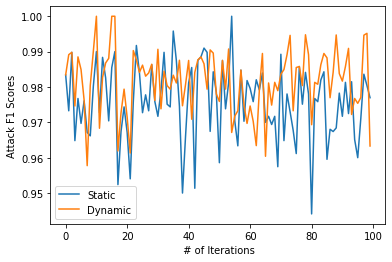

In [39]:
## F1 Score of Attack (Positive)
plt.plot(f1_attack_static, label = 'Static')
plt.plot(f1_attack_dynamic, label ='Dynamic')
plt.xlabel(" # of Iterations")
plt.legend()
plt.ylabel("Attack F1 Scores")

Text(0, 0.5, 'Average Precision Recall')

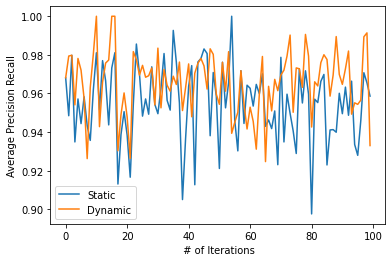

In [40]:
### Average Precision Recall
plt.plot(avg_pr_static, label = 'Static')
plt.plot(avg_pr_dynamic, label ='Dynamic')
plt.xlabel(" # of Iterations")
plt.legend()
plt.ylabel("Average Precision Recall")

# 11. Average of Performance Metrics over Iterations

In [41]:
## precision
print("Average of the Precision for Static =", round(mean(precision_static), 4))
print("Average of the Precision for Dynamic =", round(mean(precision_dynamic), 4))
print(50*'-')

## Recall
print("Average of the Recall for Static =", round(mean(recall_static), 4))
print("Average of the Recall for Dynamic =", round(mean(recall_dynamic), 4))
print(50*'-')

## F1 Score
print("Average of the Macro-F1-Score for Static =", round(mean(f1_macro_static), 4))
print("Average of the Macro-F1-Score for Dynamic =", round(mean(f1_macro_dynamic), 4))
print(50*'-')

Average of the Precision for Static = 0.9876
Average of the Precision for Dynamic = 0.9901
--------------------------------------------------
Average of the Recall for Static = 0.9856
Average of the Recall for Dynamic = 0.9896
--------------------------------------------------
Average of the Macro-F1-Score for Static = 0.9865
Average of the Macro-F1-Score for Dynamic = 0.9898
--------------------------------------------------


# 12. **Additional**: Save the performance metrics you want in pickle files for further investigation

In [42]:
## Not Mandatory so it's commented

# with open('F1_attack_static.pickle', 'wb') as handle:
#       pickle.dump(f1_attack_static, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('F1_attack_dynamic.pickle', 'wb') as handle:
#       pickle.dump(f1_attack_dynamic, handle, protocol=pickle.HIGHEST_PROTOCOL)


# **Multi-Classifiers: Problem 2**

# 2. Data Exploration

In [43]:
## read the data
df_data = pd.read_csv('iot_static_data.csv')

## check the 1st 5 rows
df_data.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,MI_dir_L0.1_mean,MI_dir_L0.1_variance,MI_dir_L0.01_weight,MI_dir_L0.01_mean,MI_dir_L0.01_variance,H_L5_weight,H_L5_mean,H_L5_variance,H_L3_weight,H_L3_mean,H_L3_variance,H_L1_weight,H_L1_mean,H_L1_variance,H_L0.1_weight,H_L0.1_mean,H_L0.1_variance,H_L0.01_weight,H_L0.01_mean,H_L0.01_variance,HH_L5_weight,HH_L5_mean,HH_L5_std,HH_L5_magnitude,HH_L5_radius,HH_L5_covariance,HH_L5_pcc,HH_L3_weight,HH_L3_mean,HH_L3_std,...,HH_jit_L0.01_weight,HH_jit_L0.01_mean,HH_jit_L0.01_variance,HpHp_L5_weight,HpHp_L5_mean,HpHp_L5_std,HpHp_L5_magnitude,HpHp_L5_radius,HpHp_L5_covariance,HpHp_L5_pcc,HpHp_L3_weight,HpHp_L3_mean,HpHp_L3_std,HpHp_L3_magnitude,HpHp_L3_radius,HpHp_L3_covariance,HpHp_L3_pcc,HpHp_L1_weight,HpHp_L1_mean,HpHp_L1_std,HpHp_L1_magnitude,HpHp_L1_radius,HpHp_L1_covariance,HpHp_L1_pcc,HpHp_L0.1_weight,HpHp_L0.1_mean,HpHp_L0.1_std,HpHp_L0.1_magnitude,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Source,Class
0,19.570634,152.679121,39991.937640,20.937891,150.455024,38960.674060,23.168006,145.454142,36954.215040,33.115077,123.515434,27655.538890,62.619034,102.471926,15409.868150,19.570634,152.679121,39991.937640,20.937891,150.455024,38960.674060,23.168006,145.454142,36954.215040,33.115077,123.515434,27655.538890,62.619034,102.471926,15409.868150,18.885473,156.041505,202.780449,349.823034,1.602610e+05,-2.956340e+04,-0.370432,20.044037,154.488822,200.790831,...,30.034811,5.307252,1.298518e+02,4.880738,181.620841,227.548005,291.835506,59579.844560,17447.876,0.446623,4.927844,181.698241,227.581665,291.280119,59578.905890,17793.81865,0.455634,4.975746,181.767997,227.609424,290.719232,5.957503e+04,1.814181e+04,0.464725,4.997565,181.796886,227.619989,290.465036,5.957232e+04,1.829905e+04,0.468843,4.999756,181.799689,2.276210e+02,290.439555,5.957202e+04,1.831480e+04,4.692557e-01,Provision PT 838 Security Camera,BENIGN
1,49.893840,169.297843,54532.338720,62.957476,169.735104,54283.995040,82.340884,168.919514,53449.819730,98.214224,164.300338,51038.672810,124.460107,146.697496,42083.223280,49.893840,169.297843,54532.338720,62.957476,169.735104,54283.995040,82.340884,168.919514,53449.819730,98.214224,164.300338,51038.672810,124.460107,146.697496,42083.223280,49.886530,169.313860,233.534964,295.273638,9.040787e+04,-2.457803e+03,-0.039193,62.898830,169.837418,233.073744,...,97.549007,1.686998,6.319929e+01,1.980432,69.960478,3.999805,101.835497,15.998438,0.000,0.000000,1.988213,69.976286,3.999930,101.846358,15.999438,0.00000,0.000000,1.996055,69.992095,3.999992,101.857221,1.599994e+01,0.000000e+00,0.000000,1.999605,69.999210,4.000000,101.862109,1.600000e+01,0.000000e+00,0.000000,1.999960,69.999921,4.000000e+00,101.862598,1.600000e+01,0.000000e+00,0.000000e+00,Provision PT 737E Security Camera,BENIGN
2,1.996527,449.011775,409.365474,2.002395,448.141152,739.076602,2.166552,419.128740,11039.485060,4.621621,278.780846,34237.687910,29.401508,286.241737,32040.668620,1.996527,449.011775,409.365474,2.002395,448.141152,739.076602,2.166552,419.128740,11039.485060,4.621621,278.780846,34237.687910,29.401508,286.241737,32040.668620,1.996402,449.036043,19.999968,449.036043,3.999987e+02,0.000000e+00,0.000000,1.997840,449.021626,19.999988,...,14.978833,10.667405,2.061570e+02,1.996402,449.036043,19.999968,449.036043,399.998701,0.000,0.000000,1.997840,449.021626,19.999988,449.021626,399.999532,0.00000,0.000000,1.999279,449.007209,19.999999,449.007209,3.999999e+02,0.000000e+00,0.000000,2.428558,450.295009,20.081460,450.295009,4.032651e+02,0.000000e+00,0.000000,14.978833,455.354366,1.959295e+01,455.354366,3.838837e+02,0.000000e+00,0.000000e+00,Samsung SNH 1011 N Webcam,BENIGN
3,1.000000,60.000018,0.004849,1.000065,60.017569,4.743299,1.063813,76.195918,4110.590208,2.936

In [44]:
## get the columns with null values greater than zero
df_data.columns[df_data.isna().sum() >0]

### No missing: The data is clean but the data has categorical features

Index([], dtype='object')

# 3. Data Cleaning 
There's a categorical features, we can encode it. However, after reading about it, it seems to be not that important and it will need further work in the streaming case. Beside, there were moments were the stream would bring some values in this feature that wasn't in the training set.
Moreover, it had low influence on the performance of the model over different classes. This feature is the "***Source***" feature.

In [45]:
df_x = df_data.loc[: , df_data.columns != 'Class' ]
print(len(df_data.columns))

df_y = df_data.loc[: , df_data.columns == 'Class']

117


In [46]:
categ = df_x.dtypes == 'object'
idx = np.where(categ)[0]
col = df_x.iloc[:, idx]
col_names_categ = col.columns
print(col_names_categ)

### Drop the categorical columns
df_x.drop(columns = col_names_categ, inplace = True)

Index(['Source'], dtype='object')


In [47]:
len(df_x.columns) 

115

# 4. Split the Data

In [48]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    df_x, df_y, stratify = df_y, test_size=0.3, random_state=42)

# 5. Classifier A (XGBoost)

**Evaluation during training by cross-val**

In [49]:
clf_m = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)

In [50]:
### Encoding here can be done easily
le = preprocessing.LabelEncoder()
y_true_enc_m = le.fit_transform(y_train_m)

In [51]:
cross_val_scores_print(clf_m, X_train_m, y_train_m, y_true_enc_m, cv=10)

Macro F1 Scores of each iteration from the 10 iterations: [0.0888162  0.86260432 0.87704347 0.94980422 0.95311771 0.78087605
 0.08876163 0.08773446 0.86756427 0.85605394]
Average Macro F1 Score of the 10 iterations: 0.6412376263318424
--------------------------------------------------
Precision Scores of each iteration from the 10 iterations: [0.08531133 0.87011192 0.86026936 0.93956106 0.97215285 0.76866627
 0.08671329 0.17503392 0.88082916 0.84103896]
Average Precision Score of the 10 iterations: 0.6479688123558395
--------------------------------------------------
Recall Scores of each iteration from the 10 iterations: [0.12587413 0.86477689 0.90903263 0.97728105 0.95099068 0.84970492
 0.09090909 0.09108392 0.8593956  0.88796929]
Average Recall of the 10 iterations: 0.6607018202824655
--------------------------------------------------


**Evaluation during test**

In [52]:
clf_m = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train_m, y_train_m)

In [53]:
y_pred_m = clf_m.predict(X_test_m)
c_report_m = classification_report(y_test_m, y_pred_m)
print(c_report_m)

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00      6686
  gafgyt_combo_attack       0.00      0.00      0.00         6
   gafgyt_junk_attack       0.96      0.96      0.96       113
   gafgyt_scan_attack       0.97      0.93      0.95        60
    gafgyt_tcp_attack       1.00      0.97      0.98        64
    gafgyt_udp_attack       0.99      1.00      0.99       134
     mirai_ack_attack       0.88      1.00      0.94        29
    mirai_scan_attack       1.00      1.00      1.00        26
     mirai_syn_attack       1.00      0.97      0.98        30
     mirai_udp_attack       1.00      1.00      1.00       532
mirai_udpplain_attack       0.60      1.00      0.75         3

             accuracy                           1.00      7683
            macro avg       0.85      0.89      0.87      7683
         weighted avg       1.00      1.00      1.00      7683



# 6. Classifier B (Decision Tree)

**Evaluation during training by cross-val**

In [54]:
clf2_m = DecisionTreeClassifier(class_weight = 'balanced', random_state=0)

In [55]:
cross_val_scores_print(clf2_m, X_train_m, y_train_m, y_true_enc_m, cv=10)

Macro F1 Scores of each iteration from the 10 iterations: [0.98880299 0.81156806 0.90872581 0.89803201 0.90572391 0.96346628
 0.81444972 0.95668596 1.         0.89305057]
Average Macro F1 Score of the 10 iterations: 0.9140505299128483
--------------------------------------------------
Precision Scores of each iteration from the 10 iterations: [0.99431818 0.81133272 0.90836364 0.89416486 0.9025974  0.99391234
 0.81408754 0.9492     1.         0.89436027]
Average Precision Score of the 10 iterations: 0.9162336953955136
--------------------------------------------------
Recall Scores of each iteration from the 10 iterations: [0.98484848 0.81212121 0.90909091 0.90291375 0.90909091 0.94848485
 0.81481481 0.98201058 1.         0.89393939]
Average Recall of the 10 iterations: 0.9157314907314907
--------------------------------------------------


**Evaluation During test**

In [56]:
clf2_m = DecisionTreeClassifier(class_weight = 'balanced', random_state=0).fit(X_train_m, y_train_m)

In [57]:
y_pred2_m = clf2_m.predict(X_test_m)

In [58]:
c_report2_m = classification_report(y_test_m, y_pred2_m)
print(c_report2_m)

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00      6686
  gafgyt_combo_attack       0.67      0.67      0.67         6
   gafgyt_junk_attack       0.98      0.98      0.98       113
   gafgyt_scan_attack       1.00      1.00      1.00        60
    gafgyt_tcp_attack       1.00      0.97      0.98        64
    gafgyt_udp_attack       0.99      1.00      0.99       134
     mirai_ack_attack       0.97      1.00      0.98        29
    mirai_scan_attack       1.00      1.00      1.00        26
     mirai_syn_attack       1.00      1.00      1.00        30
     mirai_udp_attack       1.00      1.00      1.00       532
mirai_udpplain_attack       1.00      1.00      1.00         3

             accuracy                           1.00      7683
            macro avg       0.96      0.97      0.96      7683
         weighted avg       1.00      1.00      1.00      7683



#### Training on the whole data and saving the model

In [ ]:
clf2_m = DecisionTreeClassifier(class_weight = 'balanced', random_state=0).fit(df_x, df_y)

In [59]:
dump(clf2_m, 'model_multi.bin', compress=True)

['model_multi.bin']

# **Dynamic Part (Adapt)**

# 7. Load the model and Kafka

In [60]:
model_multi = load('/content/model_multi.bin')
model_multi_adapt = load('/content/model_multi.bin')

# instantiate the KafkaConsumer Class using the arguments mentioned.
# do not change any arguments other than the first positional argument.
consumer = KafkaConsumer(
    'task2',   # change this to "task2" for the IOT Botnet Detection  ---- important ----
    bootstrap_servers="34.130.121.39:9092",
    sasl_plain_username="student",
    sasl_plain_password="uottawa",
    security_protocol="SASL_PLAINTEXT",
    sasl_mechanism="PLAIN",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

# 8. Initialization

In [61]:
df_data.drop(columns = ['Source'], inplace = True)
df_data.columns = df_data.columns.str.replace(' ','')
df_conc_multi = df_data.copy()

#### s: static, d: dynamic => subscripts are used in the multiclass problem
#### while the naming is full in case of binary classification
dict_str_problem = []
f1_attack_mirai_s = []
f1_attack_gafygt_s = []
f1_macro_s = []
precision_s = []
recall_s = []

### For Adaptive Model
f1_attack_mirai_d = []
f1_attack_gafygt_d = []
f1_macro_d = []
precision_d = []
recall_d = []

# 9. Adaptation Part (Loop)

In [62]:
for j in range(100):
    i = 0
    y_pred = []
    df_total = pd.DataFrame()
    
    for message in consumer:
        # print(f"Consuming the {i+1}th data packet!")
        data_packet = message.value

        ##############################################
        ##### 1st: Read Data ######
        ## to read in a dataframe: https://stackoverflow.com/questions/17839973/constructing-pandas-dataframe-from-values-in-variables-gives-valueerror-if-usi
        
        dict_str = data_packet.decode("UTF-8")
        ## To evade the problem of failed packets => we just skip it and get another packet
        try:
          my_data = ast.literal_eval(dict_str)
        except:
          dict_str_problem.append(dict_str)
          ## This adds the failed packets to a pickle file in order to be investigated afterwards (it happens in the Attack and Benign pkts)
          with open('failed stream.pickle', 'wb') as handle:
                pickle.dump(dict_str_problem, handle, protocol=pickle.HIGHEST_PROTOCOL)
          continue

        ## you may change this to a list or dictionary instead of complete dataframe, but the dataframe is to maintain the same names
        ### This saves only one row each time
        df = pd.DataFrame(my_data, index = [0])
        ### Drop the Source column ####
        df.drop(columns = ['Source'], inplace = True)
        df.columns = df.columns.str.replace(' ','')

        ####### 2nd: Predicting using the static model over each point from the stream #######
        x = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        
        ## Predict
        pred = model_multi.predict(x)
        ## pred is numpy array while the y_test is a series
        y_pred.append(pred)
        
        ####### Append the whole new stream in dataframe #######
        df_total = df_total.append(df, ignore_index = True)

        ###################################################################
        ######### This process continues untill we reach 1000 packets then start adapting #############

        ######## 2nd: Adapt ############
        if i == 999: 
            #### True y ####
            y_test = df_total.iloc[:, -1]

            ###### Static Model Metrics #### 
            ### Note: we've already predicted each point using the static model
            report = classification_report(y_test, y_pred, output_dict=True)
            try:
              f1_attack_mirai_s.append(report['mirai_udpplain_attack']['f1-score'])
            except: 
              ##### If the class didn't appear in the stream put it with 0
              f1_attack_mirai_s.append(0)
            try:
              f1_attack_gafygt_s.append(report['gafgyt_combo_attack']['f1-score'])
            except:
              f1_attack_gafygt_s.append(0)

            f1_macro_s.append(report['macro avg']['f1-score'])
            precision_s.append(report['macro avg']['precision'])
            recall_s.append(report['macro avg']['recall'])

            # print('f1 score for static model of attack for iteration {0} is: {1}: '.format(j, report['ATTACK']['f1-score']))

            #### Previous dynamic Model Metrics; at first it's exactly like the static #####

            y_pred_d = model_multi_adapt.predict(df_total.iloc[:, :-1])
            report_d = classification_report(y_test, y_pred_d, output_dict=True)
            try:
              f1_attack_mirai_d.append(report_d['mirai_udpplain_attack']['f1-score'])
            except: 
              ##### If the class didn't appear in the stream put it with 0
              f1_attack_mirai_d.append(0)
            try:
              f1_attack_gafygt_d.append(report_d['gafgyt_combo_attack']['f1-score'])
            except:
              f1_attack_gafygt_d.append(0)

            f1_macro_d.append(report_d['macro avg']['f1-score'])
            precision_d.append(report_d['macro avg']['precision'])
            recall_d.append(report_d['macro avg']['recall'])

            ## Start from 1000 to the rest of the dataframe: It can be (1000) instead of length
            df_reduce = df_conc_multi.iloc[len(df_total): , :]
   
            ### Concatenate the new stream with the resuced dataframe
            df_conc_multi = pd.concat([df_reduce, df_total])
            ### Check the new concatenated dataframe has the same shape each time
            print(df_conc_multi.shape)
            print("finished iteration {0}".format(j))

            #### Retrain the model ####
            X_train = df_conc_multi.iloc[:, :-1]
            y_train = df_conc_multi.iloc[:, -1]

            ### Note that "fit" always start from scratch; not like transfer learning so it's the same as initializing the model from begining #### 
            model_multi_adapt = model_multi_adapt.fit(X_train, y_train)
            break
        
        i += 1     

(25609, 116)
finished iteration 0
(25609, 116)
finished iteration 1
(25609, 116)
finished iteration 2
(25609, 116)
finished iteration 3
(25609, 116)
finished iteration 4
(25609, 116)
finished iteration 5
(25609, 116)
finished iteration 6
(25609, 116)
finished iteration 7
(25609, 116)
finished iteration 8
(25609, 116)
finished iteration 9
(25609, 116)
finished iteration 10
(25609, 116)
finished iteration 11
(25609, 116)
finished iteration 12
(25609, 116)
finished iteration 13
(25609, 116)
finished iteration 14
(25609, 116)
finished iteration 15
(25609, 116)
finished iteration 16
(25609, 116)
finished iteration 17
(25609, 116)
finished iteration 18
(25609, 116)
finished iteration 19
(25609, 116)
finished iteration 20
(25609, 116)
finished iteration 21
(25609, 116)
finished iteration 22
(25609, 116)
finished iteration 23
(25609, 116)
finished iteration 24
(25609, 116)
finished iteration 25
(25609, 116)
finished iteration 26
(25609, 116)
finished iteration 27
(25609, 116)
finished iteratio

# 10. Plot Performance metrics of the adaptation

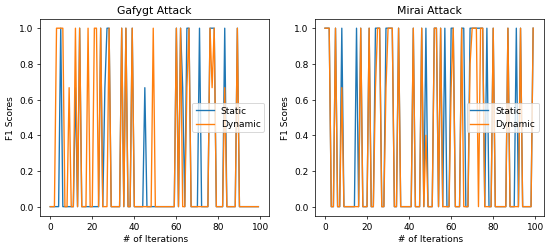

In [63]:
## F1 Score of positive Classes
fig = plt.figure(figsize=(10, 4), dpi=65)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(f1_attack_gafygt_s, label = 'Static')
ax1.plot(f1_attack_gafygt_d, label = 'Dynamic')
ax1.set_xlabel(' # of Iterations')
ax1.set_ylabel('F1 Scores')
ax1.set_title('Gafygt Attack')
ax1.legend()

ax2.plot(f1_attack_mirai_s, label = 'Static')
ax2.plot(f1_attack_mirai_d, label = 'Dynamic')
ax2.set_xlabel(' # of Iterations')
ax2.set_ylabel('F1 Scores')
ax2.set_title('Mirai Attack')
ax2.legend()

plt.show()

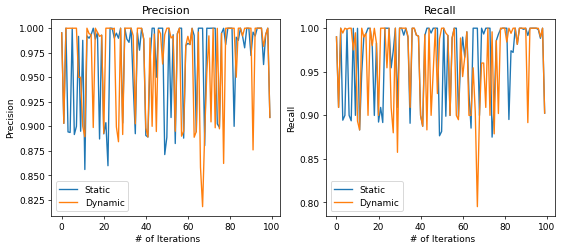

In [64]:
### Precision and Recall as there's no avg precision recall for multi class
fig = plt.figure(figsize=(10, 4), dpi=65)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(precision_s, label = 'Static')
ax1.plot(precision_d, label = 'Dynamic')
ax1.set_xlabel(' # of Iterations')
ax1.set_ylabel('Precision')
ax1.set_title('Precision')
ax1.legend()

ax2.plot(recall_s, label = 'Static')
ax2.plot(recall_d, label = 'Dynamic')
ax2.set_xlabel(' # of Iterations')
ax2.set_ylabel('Recall')
ax2.set_title('Recall')
ax2.legend()

plt.show()

# 11. Average of Performance Metrics over Iterations

In [65]:
## precision
print("Average of the Precision for Static =", round(mean(precision_s), 4))
print("Average of the Precision for Dynamic =", round(mean(precision_d), 4))
print(50*'-')

## Recall
print("Average of the Recall for Static =", round(mean(recall_s), 4))
print("Average of the Recall for Dynamic =", round(mean(recall_d), 4))
print(50*'-')

## F1 Score
print("Average of the Macro-F1-Score for Static =", round(mean(f1_macro_s), 4))
print("Average of the Macro-F1-Score for Dynamic =", round(mean(f1_macro_d), 4))
print(50*'-')

Average of the Precision for Static = 0.9665
Average of the Precision for Dynamic = 0.9659
--------------------------------------------------
Average of the Recall for Static = 0.9674
Average of the Recall for Dynamic = 0.9645
--------------------------------------------------
Average of the Macro-F1-Score for Static = 0.966
Average of the Macro-F1-Score for Dynamic = 0.9638
--------------------------------------------------


# 12. End
Notes, observations and Insights can be found in the report